In [1]:
import os
import sys
from dotenv import load_dotenv
sys.path.append("..")
sys.path.append("../src") # Adds higher directories to path (temporarily) to access our modules
from src.train_ner import main as train_ner
from src.train_image import main as train_image
from src.inference_ner import main as inference_ner
from src.inference_image import main as inference_image
from src.pipeline import main as pipeline

In [2]:
load_dotenv()
SEED = int(os.getenv('SEED'))
IMAGES_MODEL_PATH = str(os.getenv('IMAGES_MODEL_PATH'))
IMAGES_DATASET_RAW_PATH = str(os.getenv('IMAGES_DATASET_RAW_PATH'))
LOGGING_LEVEL = str(os.getenv('LOGGING_LEVEL'))
LOGGING_FORMAT = str(os.getenv('LOGGING_FORMAT'))
LOGGING_DATE_FORMAT = str(os.getenv('LOGGING_DATE_FORMAT'))

#### Let's start with testing image model
Also, considering that all parameters are set in the .env file, I won't pass any parameters to the functions

Training image model

In [2]:
train_image()

2025-02-16 17:06:14 - root - INFO - Loading dataset
2025-02-16 17:06:15 - root - INFO - Training image model
Validation: 100%|██████████| 86/86 [00:14<00:00,  5.83it/s, accuracy=0.903, loss=0.419]
2025-02-16 17:08:16 - root - INFO - Epoch 1/8, Train Loss: 1.8463133905342846, Train Accuracy: 0.6342054264143456, Validation Loss: 0.4140175081962763, Validation Accuracy: 0.9109386718550394
Validation: 100%|██████████| 86/86 [00:15<00:00,  5.70it/s, accuracy=0.968, loss=0.158] 
2025-02-16 17:10:03 - root - INFO - Epoch 2/8, Train Loss: 0.4165224394176242, Train Accuracy: 0.9014656008329502, Validation Loss: 0.2183049850945556, Validation Accuracy: 0.9433022314725921
Validation: 100%|██████████| 86/86 [00:15<00:00,  5.68it/s, accuracy=0.935, loss=0.15]  
2025-02-16 17:11:49 - root - INFO - Epoch 3/8, Train Loss: 0.22531093600704227, Train Accuracy: 0.9444343508329502, Validation Loss: 0.1812942873166744, Validation Accuracy: 0.950557951317277
Validation: 100%|██████████| 86/86 [00:14<00:00, 

Let's plot the training history

In [9]:
import joblib

history = joblib.load(os.path.join(IMAGES_MODEL_PATH, 'image_model_metrics.pkl'))

In [11]:
print(history.keys())

dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc'])


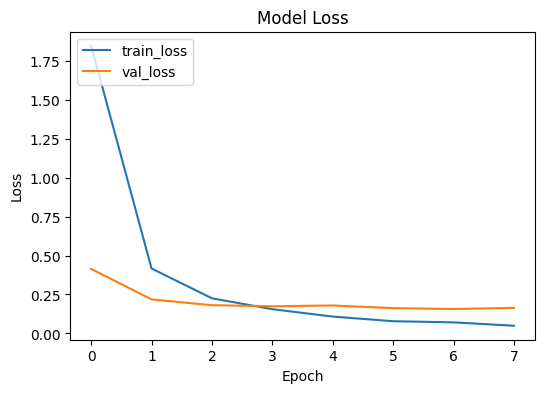

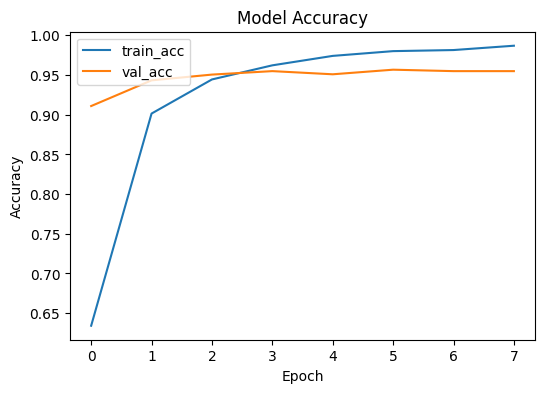

In [20]:
import matplotlib.pyplot as plt

def plot_pair_metrics(history, metric1, metric2, title, ylabel, figsize=(6, 4)):
    plt.figure(figsize=figsize)
    plt.plot(history[metric1])
    plt.plot(history[metric2])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend([metric1, metric2], loc='upper left')
    plt.show()

plot_pair_metrics(history, 'train_loss', 'val_loss', 'Model Loss', 'Loss')
plot_pair_metrics(history, 'train_acc', 'val_acc', 'Model Accuracy', 'Accuracy')

Testing inference script with a sample images (i saved four sample images in data/tesing_images folder) 

In [ ]:
for image in os.listdir('../data/testing_images'):
    _, animal = inference_image(f'../data/testing_images/{image}')
    print('-'*20)
    print(f'{image}: {animal}')
    print('-'*20)

2025-02-16 17:24:57 - root - INFO - Loading index to class mapping
2025-02-16 17:24:57 - root - INFO - Loading model
2025-02-16 17:24:57 - root - INFO - Image: ../data/testing_images/giraffe.jpg, Prediction: 12 (giraffe)
2025-02-16 17:24:57 - root - INFO - Loading index to class mapping
2025-02-16 17:24:57 - root - INFO - Loading model


--------------------
giraffe.jpg: giraffe
--------------------


2025-02-16 17:24:58 - root - INFO - Image: ../data/testing_images/red_panda.jpeg, Prediction: 27 (red_panda)
2025-02-16 17:24:58 - root - INFO - Loading index to class mapping
2025-02-16 17:24:58 - root - INFO - Loading model


--------------------
red_panda.jpeg: red_panda
--------------------


2025-02-16 17:24:58 - root - INFO - Image: ../data/testing_images/warthog.JPG, Prediction: 38 (warthog)
2025-02-16 17:24:58 - root - INFO - Loading index to class mapping
2025-02-16 17:24:58 - root - INFO - Loading model


--------------------
warthog.JPG: warthog
--------------------


2025-02-16 17:24:58 - root - INFO - Image: ../data/testing_images/weasel.jpg, Prediction: 40 (weasel)


--------------------
weasel.jpg: weasel
--------------------


As we can see our model managed to predict all the images correctly

Now let's test the model separately on whole dataset and get some additional metrics

In [29]:
from src.utils import load_image_model, evaluate_image
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose
from torchvision.models import EfficientNet_B3_Weights
import torch
from torch import nn
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = ImageFolder(IMAGES_DATASET_RAW_PATH, transform=Compose([
        EfficientNet_B3_Weights.DEFAULT.transforms(),
    ]))

loader = DataLoader(dataset, batch_size=32)

image_model = load_image_model(device=device, num_classes=len(dataset.classes), model_path=os.path.join(IMAGES_MODEL_PATH, 'image_model.pth'))

criterion = nn.CrossEntropyLoss()

loss, acc, preds, labels = evaluate_image(image_model, criterion, loader, device, return_preds=True)

Validation: 100%|██████████| 430/430 [00:54<00:00,  7.85it/s, accuracy=1, loss=0.0151]    


In [30]:
print(f'Loss: {loss}, Accuracy: {acc}')

Loss: 0.03728276514681733, Accuracy: 0.9904796511627907


In [63]:
preds_flat = []
for pred in preds:
    for pred_ in pred:
        preds_flat.append(pred_.argmax())

In [64]:
labels_flat = []
for label in labels:
    for label_ in label:
        labels_flat.append(label_)

In [66]:
print(f'Check length: {len(preds_flat)}, {len(labels_flat)}')

Check length: 13751, 13751


In [89]:
from sklearn.metrics import classification_report

print(classification_report(preds_flat, labels_flat, target_names=dataset.classes))

                  precision    recall  f1-score   support

african_elephant       1.00      1.00      1.00       346
          alpaca       0.98      0.99      0.99       330
  american_bison       1.00      0.99      0.99       345
        anteater       0.99      0.99      0.99       300
      arctic_fox       0.99      1.00      1.00       314
       armadillo       1.00      0.99      1.00       332
          baboon       1.00      1.00      1.00       330
          badger       0.99      1.00      0.99       308
      blue_whale       1.00      0.97      0.98       250
      brown_bear       0.99      1.00      0.99       296
           camel       1.00      0.98      0.99       259
         dolphin       0.98      1.00      0.99       306
         giraffe       1.00      1.00      1.00       305
       groundhog       1.00      0.99      1.00       310
 highland_cattle       1.00      0.98      0.99       317
           horse       0.99      1.00      0.99       301
          jac

Classes that are the most difficult to predict(even though we are checking with training samples) are:  
```
            precision    recall  f1-score   support
sea_lion       0.97      0.93      0.95       345
    seal       0.93      0.96      0.95       316
    yak        0.95      1.00      0.98       242
blue_whale     1.00      0.97      0.98       250
```
In general, the model is doing a great job, but it has some difficulties with similarly looking sea lions and seals.  
Further improvements can be achieved by trying different models (also, maybe it's worth trying to freeze base model weights and train only classification head, and after that unfreeze weight and fine tune all model with small learning rate), data augmentation, dataset expansion, and hyperparameter tuning.

#### Now let's check the text model

In [90]:
train_ner()

2025-02-16 18:09:53 - root - INFO - Dataset loaded
2025-02-16 18:09:53 - root - INFO - Tokenizer loaded


Map:   0%|          | 0/1474 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

2025-02-16 18:09:53 - root - INFO - Dataset tokenized
2025-02-16 18:09:53 - root - INFO - Data collator created
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.025700,0.000077,1.000000,1.000000,1.000000,1.000000
2,0.000600,0.000049,1.000000,1.000000,1.000000,1.000000
3,0.000100,0.000037,1.000000,1.000000,1.000000,1.000000


2025-02-16 18:10:22 - root - INFO - Model trained
2025-02-16 18:10:23 - root - INFO - Model saved


We have a small and not very diverse dataset, so BERT adapts well to it and gives us 100% for all metrics

Let's try ner inference script with some sample text

In [2]:
text = "Oak is on the farm"
result = inference_ner(text)
print('-'*80)
text = "The brown fox jumps over the rhinoceros"
result = inference_ner(text)
print('-'*80)
text = "The quick brown fox jumps over the lazy dog"
result = inference_ner(text)
print('-'*80)
text = "John and Jane went to sea to see the dolphins"
result = inference_ner(text)

2025-02-16 18:43:29 - root - INFO - Model loaded
2025-02-16 18:43:29 - root - INFO - Tokenizer loaded
Device set to use cuda:0
2025-02-16 18:43:29 - root - INFO - NER pipeline created
2025-02-16 18:43:29 - root - INFO - Result: [{'entity': 'B-ANIMAL', 'score': 0.607843, 'index': 1, 'word': 'Oak', 'start': 0, 'end': 3}]
2025-02-16 18:43:29 - root - INFO - Model loaded
2025-02-16 18:43:29 - root - INFO - Tokenizer loaded
Device set to use cuda:0
2025-02-16 18:43:29 - root - INFO - NER pipeline created


Word: Oak, Start: 0, End: 3
Entity: B-ANIMAL, Score: 0.6078429818153381

--------------------------------------------------------------------------------


2025-02-16 18:43:29 - root - INFO - Result: [{'entity': 'B-ANIMAL', 'score': 0.99985445, 'index': 2, 'word': 'brown', 'start': 4, 'end': 9}, {'entity': 'I-ANIMAL', 'score': 0.99987733, 'index': 3, 'word': 'fox', 'start': 10, 'end': 13}, {'entity': 'B-ANIMAL', 'score': 0.9998122, 'index': 7, 'word': 'r', 'start': 29, 'end': 30}, {'entity': 'I-ANIMAL', 'score': 0.9998884, 'index': 8, 'word': '##hino', 'start': 30, 'end': 34}, {'entity': 'I-ANIMAL', 'score': 0.9998722, 'index': 9, 'word': '##cer', 'start': 34, 'end': 37}, {'entity': 'I-ANIMAL', 'score': 0.99990726, 'index': 10, 'word': '##os', 'start': 37, 'end': 39}]
2025-02-16 18:43:29 - root - INFO - Model loaded
2025-02-16 18:43:29 - root - INFO - Tokenizer loaded
Device set to use cuda:0
2025-02-16 18:43:30 - root - INFO - NER pipeline created


Word: brown, Start: 4, End: 9
Entity: B-ANIMAL, Score: 0.9998544454574585

Word: fox, Start: 10, End: 13
Entity: I-ANIMAL, Score: 0.9998773336410522

Word: r, Start: 29, End: 30
Entity: B-ANIMAL, Score: 0.9998121857643127

Word: ##hino, Start: 30, End: 34
Entity: I-ANIMAL, Score: 0.9998884201049805

Word: ##cer, Start: 34, End: 37
Entity: I-ANIMAL, Score: 0.9998722076416016

Word: ##os, Start: 37, End: 39
Entity: I-ANIMAL, Score: 0.9999072551727295

--------------------------------------------------------------------------------


2025-02-16 18:43:30 - root - INFO - Result: [{'entity': 'B-ANIMAL', 'score': 0.97171164, 'index': 2, 'word': 'quick', 'start': 4, 'end': 9}, {'entity': 'B-ANIMAL', 'score': 0.98775405, 'index': 3, 'word': 'brown', 'start': 10, 'end': 15}, {'entity': 'I-ANIMAL', 'score': 0.99981433, 'index': 4, 'word': 'fox', 'start': 16, 'end': 19}, {'entity': 'B-ANIMAL', 'score': 0.998701, 'index': 8, 'word': 'lazy', 'start': 35, 'end': 39}, {'entity': 'I-ANIMAL', 'score': 0.999673, 'index': 9, 'word': 'dog', 'start': 40, 'end': 43}]
2025-02-16 18:43:30 - root - INFO - Model loaded
2025-02-16 18:43:30 - root - INFO - Tokenizer loaded
Device set to use cuda:0
2025-02-16 18:43:30 - root - INFO - NER pipeline created


Word: quick, Start: 4, End: 9
Entity: B-ANIMAL, Score: 0.9717116355895996

Word: brown, Start: 10, End: 15
Entity: B-ANIMAL, Score: 0.9877540469169617

Word: fox, Start: 16, End: 19
Entity: I-ANIMAL, Score: 0.9998143315315247

Word: lazy, Start: 35, End: 39
Entity: B-ANIMAL, Score: 0.9987009763717651

Word: dog, Start: 40, End: 43
Entity: I-ANIMAL, Score: 0.9996730089187622

--------------------------------------------------------------------------------


2025-02-16 18:43:30 - root - INFO - Result: [{'entity': 'B-ANIMAL', 'score': 0.9997429, 'index': 10, 'word': 'do', 'start': 37, 'end': 39}, {'entity': 'I-ANIMAL', 'score': 0.9998735, 'index': 11, 'word': '##lphin', 'start': 39, 'end': 44}]


Word: do, Start: 37, End: 39
Entity: B-ANIMAL, Score: 0.9997429251670837

Word: ##lphin, Start: 39, End: 44
Entity: I-ANIMAL, Score: 0.9998735189437866



Here we can see that the model doesn't work well with all examples.  
- In the first example model recognized Oak as animal, but it is a tree.  
- In the second example model correctly recognized brown fox and rhinoceros.  
- In the third example model recognized adjectives 'quick' and 'lazy' as animals.  
- And in the last example we can see that because there were not plural forms in the dataset, model recognized 'do' and '##lphin' without 's'.  

To improve the model we need definitely need more data and it should be more diverse to cover different cases.

#### Finally, let's check the pipeline

In [4]:
text = 'There is a giraffe on the image'
image = '../data/testing_images/giraffe.jpg'
result_bool = pipeline(text=text, image_path=image)
print(f'Prediction: {result_bool}')

print('-'*80)

text = 'Is there a red panda on the image?'
image = '../data/testing_images/red_panda.jpeg'
result_bool = pipeline(text=text, image_path=image)
print(f'Prediction: {result_bool}')

print('-'*80)

text = 'There is a warthog on the image'
image = '../data/testing_images/warthog.JPG'
result_bool = pipeline(text=text, image_path=image)
print(f'Prediction: {result_bool}')

print('-'*80)

text = 'Image contains a weasel'
image = '../data/testing_images/weasel.jpg'
result_bool = pipeline(text=text, image_path=image)
print(f'Prediction: {result_bool}')

print('-'*80)
text = 'Image contains a horse'
image = '../data/testing_images/weasel.jpg'
result_bool = pipeline(text=text, image_path=image)
print(f'Prediction: {result_bool}')

2025-02-16 18:45:39 - root - INFO - Running NER inference on text
2025-02-16 18:45:39 - root - INFO - Model loaded
2025-02-16 18:45:39 - root - INFO - Tokenizer loaded
Device set to use cuda:0
2025-02-16 18:45:39 - root - INFO - NER pipeline created
2025-02-16 18:45:39 - root - INFO - Result: [{'entity': 'B-ANIMAL', 'score': 0.999637, 'index': 4, 'word': 'g', 'start': 11, 'end': 12}, {'entity': 'I-ANIMAL', 'score': 0.9998653, 'index': 5, 'word': '##ira', 'start': 12, 'end': 15}, {'entity': 'I-ANIMAL', 'score': 0.99990404, 'index': 6, 'word': '##ffe', 'start': 15, 'end': 18}]
2025-02-16 18:45:39 - root - INFO - Running image inference
2025-02-16 18:45:39 - root - INFO - Loading index to class mapping
2025-02-16 18:45:39 - root - INFO - Loading model
2025-02-16 18:45:40 - root - INFO - Image: ../data/testing_images/giraffe.jpg, Prediction: 12 (giraffe)
2025-02-16 18:45:40 - root - INFO - Running NER inference on text
2025-02-16 18:45:40 - root - INFO - Model loaded
2025-02-16 18:45:40 - 

Prediction: True
--------------------------------------------------------------------------------


2025-02-16 18:45:40 - root - INFO - NER pipeline created
2025-02-16 18:45:40 - root - INFO - Result: [{'entity': 'B-ANIMAL', 'score': 0.99969685, 'index': 4, 'word': 'red', 'start': 11, 'end': 14}, {'entity': 'I-ANIMAL', 'score': 0.9998266, 'index': 5, 'word': 'pan', 'start': 15, 'end': 18}, {'entity': 'I-ANIMAL', 'score': 0.9998894, 'index': 6, 'word': '##da', 'start': 18, 'end': 20}]
2025-02-16 18:45:40 - root - INFO - Running image inference
2025-02-16 18:45:40 - root - INFO - Loading index to class mapping
2025-02-16 18:45:40 - root - INFO - Loading model
2025-02-16 18:45:40 - root - INFO - Image: ../data/testing_images/red_panda.jpeg, Prediction: 27 (red_panda)
2025-02-16 18:45:40 - root - INFO - Running NER inference on text
2025-02-16 18:45:40 - root - INFO - Model loaded
2025-02-16 18:45:40 - root - INFO - Tokenizer loaded
Device set to use cuda:0


Prediction: True
--------------------------------------------------------------------------------


2025-02-16 18:45:40 - root - INFO - NER pipeline created
2025-02-16 18:45:40 - root - INFO - Result: [{'entity': 'B-ANIMAL', 'score': 0.9998301, 'index': 4, 'word': 'war', 'start': 11, 'end': 14}, {'entity': 'I-ANIMAL', 'score': 0.99987257, 'index': 5, 'word': '##th', 'start': 14, 'end': 16}, {'entity': 'I-ANIMAL', 'score': 0.99988616, 'index': 6, 'word': '##og', 'start': 16, 'end': 18}]
2025-02-16 18:45:40 - root - INFO - Running image inference
2025-02-16 18:45:40 - root - INFO - Loading index to class mapping
2025-02-16 18:45:40 - root - INFO - Loading model
2025-02-16 18:45:41 - root - INFO - Image: ../data/testing_images/warthog.JPG, Prediction: 38 (warthog)
2025-02-16 18:45:41 - root - INFO - Running NER inference on text
2025-02-16 18:45:41 - root - INFO - Model loaded
2025-02-16 18:45:41 - root - INFO - Tokenizer loaded
Device set to use cuda:0


Prediction: True
--------------------------------------------------------------------------------


2025-02-16 18:45:41 - root - INFO - NER pipeline created
2025-02-16 18:45:41 - root - INFO - Result: [{'entity': 'B-ANIMAL', 'score': 0.999666, 'index': 4, 'word': 'we', 'start': 17, 'end': 19}, {'entity': 'I-ANIMAL', 'score': 0.999841, 'index': 5, 'word': '##ase', 'start': 19, 'end': 22}, {'entity': 'I-ANIMAL', 'score': 0.9967368, 'index': 6, 'word': '##l', 'start': 22, 'end': 23}]
2025-02-16 18:45:41 - root - INFO - Running image inference
2025-02-16 18:45:41 - root - INFO - Loading index to class mapping
2025-02-16 18:45:41 - root - INFO - Loading model
2025-02-16 18:45:41 - root - INFO - Image: ../data/testing_images/weasel.jpg, Prediction: 40 (weasel)
2025-02-16 18:45:41 - root - INFO - Running NER inference on text
2025-02-16 18:45:41 - root - INFO - Model loaded
2025-02-16 18:45:41 - root - INFO - Tokenizer loaded
Device set to use cuda:0


Prediction: True
--------------------------------------------------------------------------------


2025-02-16 18:45:41 - root - INFO - NER pipeline created
2025-02-16 18:45:42 - root - INFO - Result: [{'entity': 'B-ANIMAL', 'score': 0.9946138, 'index': 4, 'word': 'horse', 'start': 17, 'end': 22}]
2025-02-16 18:45:42 - root - INFO - Running image inference
2025-02-16 18:45:42 - root - INFO - Loading index to class mapping
2025-02-16 18:45:42 - root - INFO - Loading model
2025-02-16 18:45:42 - root - INFO - Image: ../data/testing_images/weasel.jpg, Prediction: 40 (weasel)


Prediction: False


#### As we can see our pipeline works as expected and we can get correct predictions for our examples